<h1><center>Calculate Busbar/Magnet Resistance for a ramp-up</center></h1>
In order to remove the inductive voltage from resistance calculation, the calculation is performed from voltage and current queried during beam injection and stable beams. 
The beam mode is represented by an index from 1 to 22.
A detailed description is available at: <a href = "https://lhc-commissioning.web.cern.ch/lhc-commissioning/systems/data-exchange/published-topics/beam-modes.htm">https://lhc-commissioning.web.cern.ch/lhc-commissioning/systems/data-exchange/published-topics/beam-modes.htm</a>.

In order to detect a full ramp-up, indices 2,6,8,14 are used as shown below. The duration of injection and stable beam periods should be 30 minutes, each.
<img src = "figures/voltage_current.PNG">
Presented calculations are based on the work of Zinur Charifoulline, and Christoph Obermair.
For further details, please refer to [1], [2], and [3].

[1] Z. Charifoulline, M. J. Bednarek, R. Denz, S. Le Naour, C. Scheuerlein, A. Siemko, J. Steckert, J.-P. Tock, A. Verweij, and M. Zerlauth, “Resistance of Splices in the LHC Main Superconducting Magnet Circuits at 1.9 K,” IEEE Transactions on Applied Superconductivity, vol. 28, no. 3, pp. 1–5, Apr. 2018. [Online]. Available: http://ieeexplore.ieee.org/document/8219360/

[2] C. Obermair, SUMM Report: http://cds.cern.ch/record/2639871?ln=en

[3] C. Obermair, Final Presentation: https://indico.cern.ch/event/758122/

# 0. Initialise the working environment
## 0.1. Connect to the cluster (NXCALS)
To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready
* Make sure that the NXCALS option is enabled.

## 0.2. Import useful packages

In [1]:
# External libraries
import numpy as np
import pandas as pd
from functools import reduce

# NXCALS libraries
from cern.nxcals.pyquery.builders import *

# Spark libraries
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Internal libraries
from lhcsmapi.Time import Time
from lhcsmapi.dbsignal.Signal import Signal
from lhcsmapi.reference.Reference import Reference
from lhcsmapi.dbsignal.SignalAnalysis import SignalAnalysis
from lhcsmapi.dbsignal.SignalUtilities import SignalUtilities
from lhcsmapi.metadata.SignalMetadata import SignalMetadata
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from lhcsmapi.analysis.CircuitQuery import CircuitQuery
from lhcsmapi.analysis.busbar.BusbarResistanceAnalysis import get_complete_busbar_df, find_plateau_start_and_end, find_start_end_of_the_longest_ramp_up

## 0.3. LHCSMAPI Version

In [2]:
import lhcsmapi
print('Analysis executed with lhcsmapi version: {}'.format(lhcsmapi.__version__))

Analysis executed with lhcsmapi version: 1.3.253


# 1. Choose a period

# User input



In [3]:
t_start_beam_mode = "2018-05-21 00:00:00.00"
t_end_beam_mode = "2018-05-22 00:00:00.00"
circuit_type = 'RB' # 'RB', 'RQ'
circuit_name = 'RB.A12'
signal_type = 'U_MAG'

# 2. Display Beam Mode Description

In [4]:
SignalMetadata.get_beam_mode_details()

Mode      Name                              Description
0      1    NOMODE  No mode, data is not available, not set
1      2     SETUP                                    Setup
2      3  INJPILOT                          Pilot injection
3      4   INJINTR                   Intermediate injection
4      5   INJNOMN                        Nominal injection
5      6   PRERAMP                              Before ramp
6      7      RAMP                                     Ramp
7      8   FLATTOP                                 Flat top
8      9   SQUEEZE                                  Squeeze
9     10    ADJUST                  Adjust beam on flat top
10    11    STABLE                  Stable beam for physics
11    12  UNSTABLE                            Unstable beam
12    13  BEAMDUMP                                Beam dump
13    14  RAMPDOWN                                Ramp down
14    15  RECOVERY                               Recovering
15    16   INJDUMP                          Inject and dump
16    17  CIRCDUMP                       Circulate and dump
17    18     ABORT   Recovery after a beam permit flag drop
18    19   CYCLING      Pre-cycle before injection, no beam
19    20    WBDUMP                        Warning beam dump
20    21    NOBEAM          No beam or preparation for beam

# 3. Find a beam mode pattern from injection to stable beams
## 3.1. Query NXCALS for beam mode

In [5]:
pattern = ['SETUP', 'PRERAMP', 'FLATTOP', 'RAMPDOWN']
pattern_str = '\'SETUP\', \'PRERAMP\', \'FLATTOP\', \'RAMPDOWN\''
beam_mode_ds = VariableQuery.builder(spark)\
                    .system('CMW').startTime(t_start_beam_mode).endTime(t_end_beam_mode)\
                    .variable('HX:BMODE')\
                    .buildDataset() # 1: query spark, returns dataset
beam_mode_df = beam_mode_ds.sort("nxcals_timestamp").where(
    reduce(lambda a, b: a|b, (beam_mode_ds['nxcals_value'].like('%'+pat+"%") for pat in pattern))
    ).toPandas() # sort pattern after time, returns pandas dataFrame 
beam_mode_df = beam_mode_df.set_index("nxcals_timestamp") # index is timestamp
beam_mode_df.head() # show head of query

nxcals_value  nxcals_entity_id nxcals_variable_name
nxcals_timestamp                                                       
1526880872073000000     RAMPDOWN           1634073             HX:BMODE
1526883413284000000        SETUP           1634073             HX:BMODE
1526899957236000000      PRERAMP           1634073             HX:BMODE
1526901552338000000      FLATTOP           1634073             HX:BMODE
1526932407376000000     RAMPDOWN           1634073             HX:BMODE

In [6]:
mapping = {'SETUP': 2.0, 'PRERAMP': 6.0, 'FLATTOP': 8.0, 'RAMPDOWN': 14.0} # create map 
beam_mode_df['nxcals_value'] = beam_mode_df.apply(lambda col: mapping[col['nxcals_value']], axis=1) # replace value names with number, lambda expression, axis = 1 ?
beam_mode_df.head() # show head of query

nxcals_value  nxcals_entity_id nxcals_variable_name
nxcals_timestamp                                                        
1526880872073000000          14.0           1634073             HX:BMODE
1526883413284000000           2.0           1634073             HX:BMODE
1526899957236000000           6.0           1634073             HX:BMODE
1526901552338000000           8.0           1634073             HX:BMODE
1526932407376000000          14.0           1634073             HX:BMODE

## 3.2. Filter a beam mode pattern for injection -> ramp-up -> stable beams -> ramp-down: [2, 6, 8, 14]
### 3.2.1. Filter rows containing the exact pattern

In [7]:
pattern = [2.0, 6.0, 8.0, 14.0] 
exact_pattern_df, _ = SignalAnalysis.find_rows_with_exact_pattern_in_series(beam_mode_df["nxcals_value"], pattern) # filter excact pattern #, _ = ? 
exact_pattern_df

2.0                  6.0                  8.0   \
0  1526883413284000000  1526899957236000000  1526901552338000000   

                  14.0  
0  1526932407376000000

### 3.2.1. Filter rows containing the pattern with the prescribed duration
- [2, 6] for 1800 s
- [8, 14] for 1800 s

In [8]:
exact_pattern_df['is_sb_long_enough'] = (exact_pattern_df[14.0] - exact_pattern_df[8.0] > 1800*1e9) # true if long enough
exact_pattern_long_enough_df = exact_pattern_df.query('is_sb_long_enough == True') # query those who are long enough
exact_pattern_long_enough_df

2.0                  6.0                  8.0  \
0  1526883413284000000  1526899957236000000  1526901552338000000   

                  14.0  is_sb_long_enough  
0  1526932407376000000               True

# 4. Ramp duration for resistance calculation
- For the beam injection, the duration considered is at maximum 30 minutes. In other words, if the time between beam mode 2.0 (setup) and 6.0 (ramp) is less than 30 minutes, then this period is considered, otherwise, the injection time is 30 minutes.
- For the stable beams, the duration considered is exactly 30 minutes. This means that shorter stable beams periods are discarded and longer are truncated to first 30 minutes.

In [9]:
t_setups =  exact_pattern_long_enough_df[2].values # Time for 2
t_preramps =  exact_pattern_long_enough_df[6].values # Time for 6
t_flattops = exact_pattern_long_enough_df[8].values # Time for 8
t_start_injs = np.array([max(t_s, t_p-int(1800*1e9)) for t_s, t_p in zip(t_setups, t_preramps)]) # Aggregates setup and preamps in tuple
t_end_injs = t_preramps # Marks end of injection
t_start_sbs = t_flattops # Start of stable beam period
t_end_sbs = t_start_sbs + int(1800*1e9) # Duration of stable beam is 30 min after stable

In [10]:
print('Start Injection:', t_start_injs)
print('End Injection:', t_end_injs)
print('Start StableBeam:', t_start_sbs)
print('End StableBeam:', t_end_sbs)

Start Injection: [1526898157236000000]
End Injection: [1526899957236000000]
Start StableBeam: [1526901552338000000]
End StableBeam: [1526903352338000000]


# 5. Query I_MEAS
- The start time is the first row
- The end time is the last row

## 5.1. From t_start_inj to t_end_sb
### 5.1.1. Query NXCALS

In [11]:
from lhcsmapi.pyedsl.QueryBuilder import QueryBuilder

i_meas_raw_df = QueryBuilder().with_nxcals(spark) \
        .with_duration(t_start=t_start_injs[0], t_end=int(t_end_sbs[0])) \
        .with_circuit_type(circuit_type) \
        .with_metadata(circuit_name=circuit_name, system='PC', signal='I_MEAS') \
        .signal_query() \
        .dfs[0]

### 5.1.2. Find Current Plateaus

In [12]:
plateau_start, plateau_end = find_plateau_start_and_end(i_meas_raw_df, i_meas_threshold=50)
ramp_up_start, ramp_up_end = find_start_end_of_the_longest_ramp_up(plateau_start, plateau_end)

ax = i_meas_raw_df.plot(figsize=(15, 7))
for ps, pe in zip(plateau_start, plateau_end):
    ax.axvspan(xmin=ps, xmax=pe, facecolor='xkcd:green')

ax.axvspan(xmin=ramp_up_start, xmax=ramp_up_end, facecolor='xkcd:yellowgreen')

## 5.2. For current plateaus
- get max, mean and standard deviation values

In [13]:
# Label columns with a function for current and voltage
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import numpy as np

plateau_start = np.array(plateau_start)
plateau_end = np.array(plateau_end)

def translate(timestamp):
    mask_plateau = (timestamp >= plateau_start) & (timestamp <= plateau_end)
    index_plateau = np.where(mask_plateau == True)[0]

    if len(index_plateau) > 0:
        return int((index_plateau[0]+1))
    
    if (timestamp > ramp_up_start) and (timestamp < ramp_up_end):
        return 0

    return -1

translate_udf = udf(translate, IntegerType())

i_meas_features_df = QueryBuilder() \
    .with_nxcals(spark) \
    .with_duration(t_start=t_start_injs[0], t_end=int(t_end_sbs[0])) \
    .with_circuit_type(circuit_type) \
    .with_metadata(circuit_name=circuit_name, system='PC', signal='I_MEAS') \
    .feature_query(['mean', 'std', 'max', 'min', 'count'], function=translate_udf) \
    .sort_values(by='class') \
    .df

In [14]:
i_meas_features_df

device class       min count          std       max          mean
0  RPTE.UA23.RB.A12     0    762.57  2358  3182.061136  10978.41   5388.826527
1  RPTE.UA23.RB.A12     1    757.18    80     0.781295    761.44    757.403375
2  RPTE.UA23.RB.A12     2  10978.77    60     0.007552  10978.80  10978.781500

# 6. Query U_RES, U_MAG

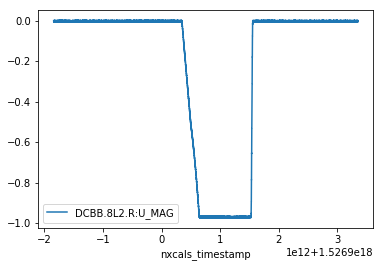

In [15]:
u_mag_raw_df = QueryBuilder().with_nxcals(spark) \
    .with_duration(t_start=t_start_injs[0], t_end=int(t_end_sbs[0])) \
    .with_circuit_type('RB') \
    .with_metadata(circuit_name='RB.A12', system='BUSBAR', signal=signal_type, wildcard={'BUSBAR': 'DCBB.8L2.R'}) \
    .signal_query().dfs[0]

u_mag_raw_df.plot()

In [16]:
u_mag_features_df = QueryBuilder().with_nxcals(spark) \
    .with_duration(t_start=t_start_injs[0], t_end=int(t_end_sbs[0])) \
    .with_circuit_type('RB') \
    .with_metadata(circuit_name='RB.A12', system='BUSBAR', signal=signal_type, wildcard={'BUSBAR': 'DCBB.8L2.R'}) \
    .feature_query(['mean', 'std', 'max', 'min', 'count'], function=translate_udf).df

u_mag_features_df

nxcals_variable_name class       min  count       std       max      mean
0     DCBB.8L2.R:U_MAG     1 -0.035768  21775  0.003133  0.002113 -0.001944
1     DCBB.8L2.R:U_MAG     0 -0.975332  12485  0.294665  0.001223 -0.812338
2     DCBB.8L2.R:U_MAG     2 -0.006084  17405  0.002807  0.002003 -0.001960

# 7. Calculate Resistance for the Entire Circuit
## 7.1. Query Current

In [19]:
i_meas_raw_dfs = QueryBuilder().with_nxcals(spark) \
        .with_duration(t_start=t_start_injs[0], t_end=int(t_end_sbs[0])) \
        .with_circuit_type(circuit_type) \
        .with_metadata(circuit_name='*', system='PC', signal='I_MEAS') \
        .signal_query() \
        .dfs

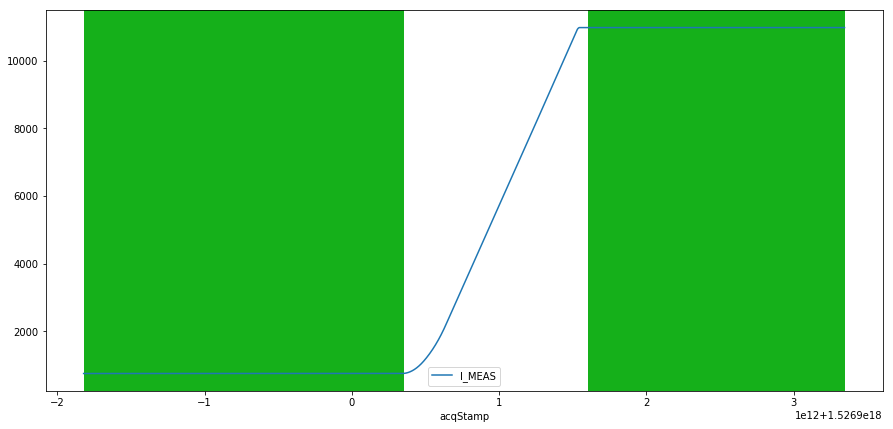

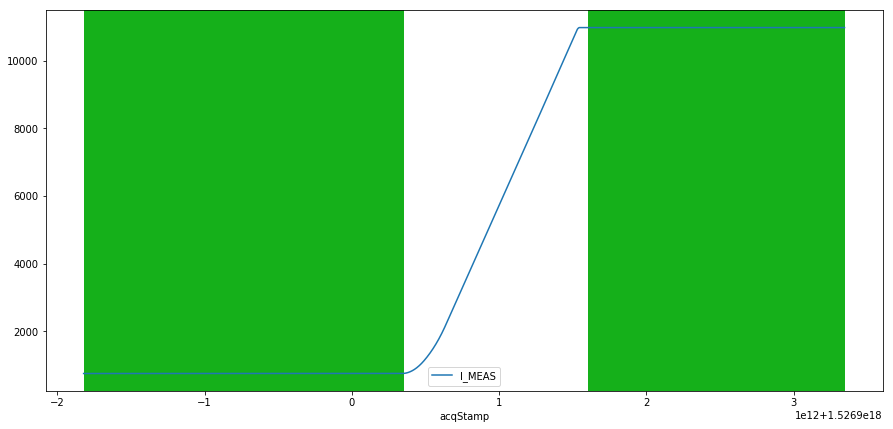

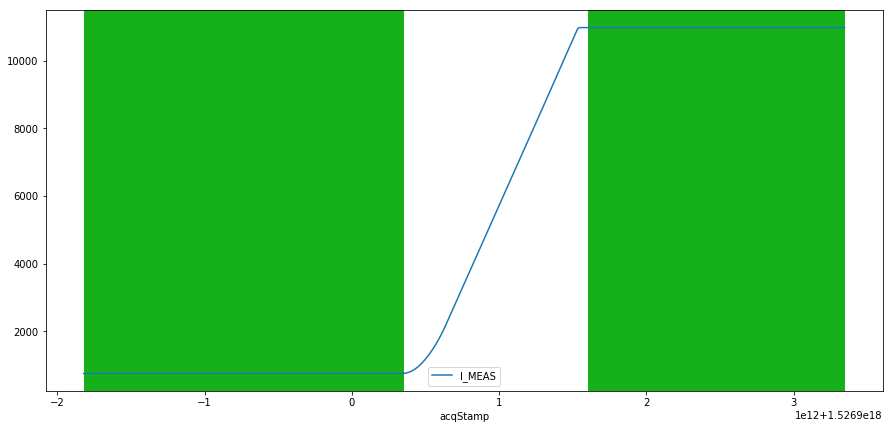

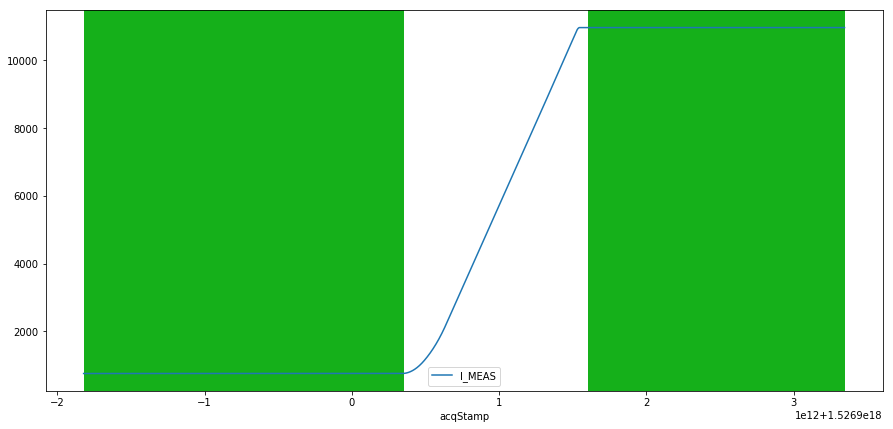

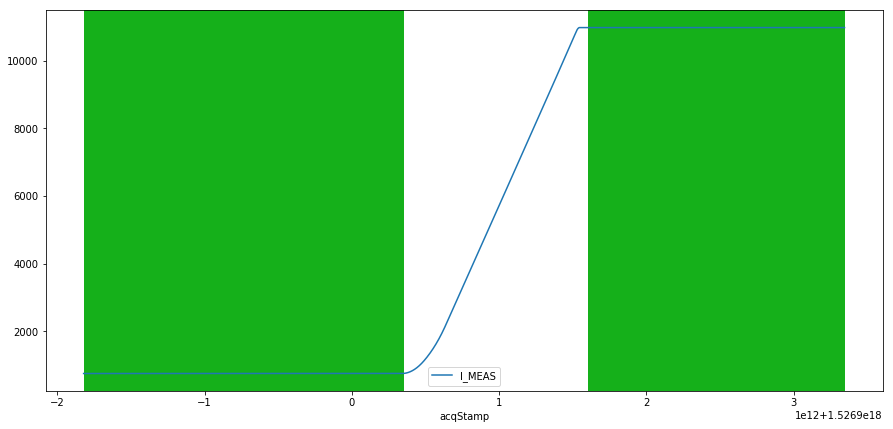

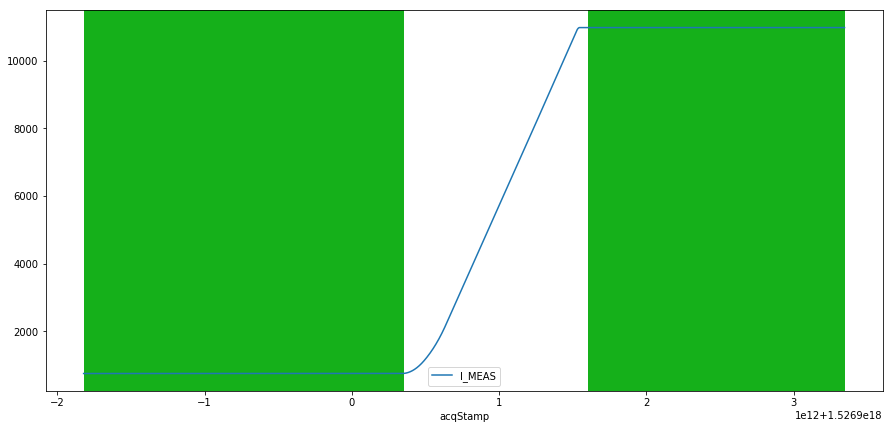

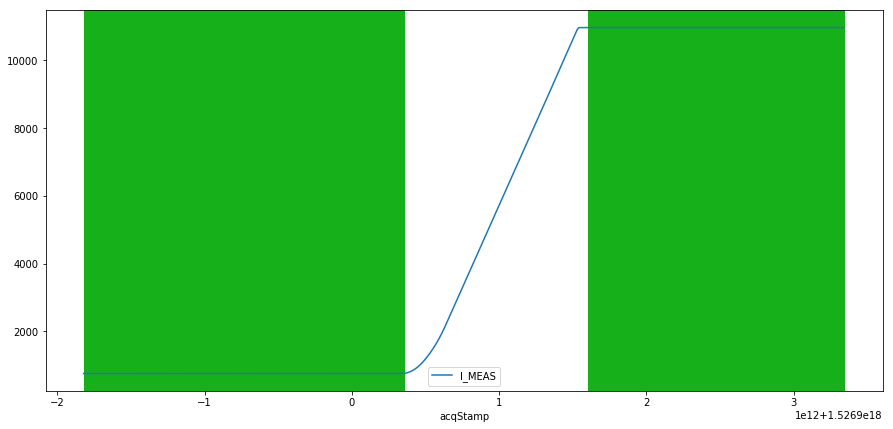

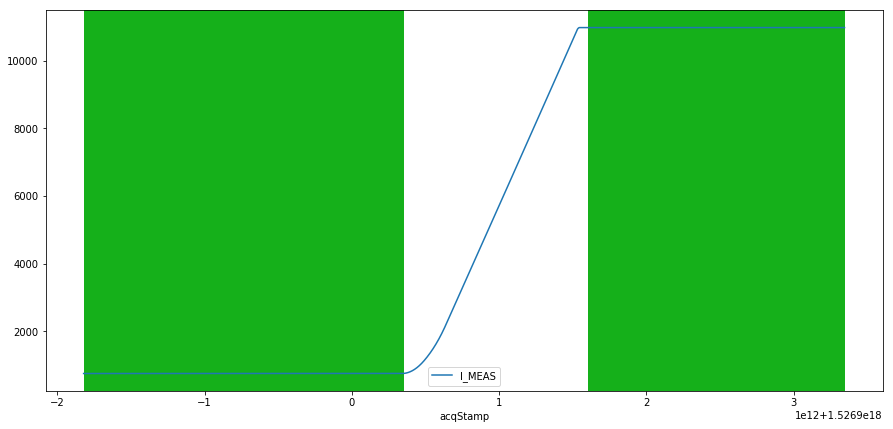

In [20]:
plateau_starts = []
plateau_ends = []

for i_meas_raw_df in i_meas_raw_dfs:
    if i_meas_raw_df.max().values[0] > 100:
        plateau_start, plateau_end = find_plateau_start_and_end(i_meas_raw_df, i_meas_threshold=50)
        plateau_starts.append(plateau_start)
        plateau_ends.append(plateau_end)
        ax = i_meas_raw_df.plot(figsize=(15, 7))
        for ps, pe in zip(plateau_start, plateau_end):
            ax.axvspan(xmin=ps, xmax=pe, facecolor='xkcd:green')

In [21]:
plateau_start = np.array(max(plateau_starts))
plateau_end = np.array(min(plateau_ends))

def translate(timestamp):
    mask_plateau = (timestamp >= plateau_start) & (timestamp <= plateau_end)
    index_plateau = np.where(mask_plateau == True)[0]

    if len(index_plateau) > 0:
        return int((index_plateau[0]+1))
    
    if (timestamp > ramp_up_start) and (timestamp < ramp_up_end):
        return 0

    return -1

translate_udf = udf(translate, IntegerType())

In [22]:
i_meas_feature_df = QueryBuilder() \
        .with_nxcals(spark) \
        .with_duration(t_start=t_start_injs[0], t_end=int(t_end_sbs[0])) \
        .with_circuit_type(circuit_type) \
        .with_metadata(circuit_name='*', system='PC', signal='I_MEAS') \
        .feature_query(['mean', 'std'], function=translate_udf) \
        .sort_values(by='class') \
        .df

i_meas_feature_df

device class          std          mean
0   RPTE.UA27.RB.A23     0  3181.445952   5388.048338
1   RPTE.UA47.RB.A45     0  3180.270644   5387.364338
2   RPTE.UA63.RB.A56     0  3180.790425   5386.690517
3   RPTE.UA67.RB.A67     0  3182.596812   5392.699835
4   RPTE.UA23.RB.A12     0  3182.061136   5388.826527
5   RPTE.UA83.RB.A78     0  3179.550049   5387.584754
6   RPTE.UA87.RB.A81     0  3181.036618   5389.951450
7   RPTE.UA43.RB.A34     0  3180.715854   5391.984735
8   RPTE.UA87.RB.A81     1     0.967716    757.098228
9   RPTE.UA27.RB.A23     1     0.784807    757.249125
10  RPTE.UA83.RB.A78     1     0.965149    756.738750
11  RPTE.UA47.RB.A45     1     0.816308    756.923846
12  RPTE.UA43.RB.A34     1     0.959976    757.228734
13  RPTE.UA67.RB.A67     1     0.971061    757.458861
14  RPTE.UA23.RB.A12     1     0.790681    757.408590
15  RPTE.UA63.RB.A56     1     0.789527    757.110256
16  RPTE.UA27.RB.A23     2     0.001825  10976.450339
17  RPTE.UA43.RB.A34     2     0.005042  10975.154915
18  RPTE.UA83.RB.A78     2     0.000000  10967.940000
19  RPTE.UA87.RB.A81     2     0.002809  10973.209153
20  RPTE.UA47.RB.A45     2     0.001825  10971.439661
21  RPTE.UA23.RB.A12     2     0.007364  10978.781897
22  RPTE.UA67.RB.A67     2     0.001302  10978.550169
23  RPTE.UA63.RB.A56     2     0.001313  10974.350172

## 7.2. Query Voltage

In [24]:
u_mag_feature_df = QueryBuilder() \
        .with_nxcals(spark) \
        .with_duration(t_start=t_start_injs[0], t_end=int(t_end_sbs[0])) \
        .with_circuit_type(circuit_type) \
        .with_metadata(circuit_name='*', system='BUSBAR', signal=signal_type, wildcard={'BUSBAR': '*'}) \
        .feature_query(['mean', 'std'], function=translate_udf) \
        .sort_busbar_location(circuit_type, circuit_name='*') \
        .correct_voltage_sign() \
        .df

u_mag_feature_df

nxcals_variable_name class       std      mean
0        DCBB.8L2.R:U_MAG     0  0.293337  0.813517
1        DCBB.8L2.R:U_MAG     1  0.003317  0.001976
2        DCBB.8L2.R:U_MAG     2  0.002807  0.001960
3        DCBB.9L2.R:U_MAG     0  0.292931  0.812749
4        DCBB.9L2.R:U_MAG     2  0.000967  0.001764
5        DCBB.9L2.R:U_MAG     1  0.001932  0.001843
6       DCBB.10L2.R:U_MAG     2  0.000962 -0.001789
7       DCBB.10L2.R:U_MAG     1  0.001927 -0.001747
8       DCBB.10L2.R:U_MAG     0  0.292835  0.808725
9       DCBB.11L2.R:U_MAG     0  0.293059  0.812512
10      DCBB.11L2.R:U_MAG     2  0.002386  0.001418
11      DCBB.11L2.R:U_MAG     1  0.002793  0.001491
12     DCBB.A12L2.R:U_MAG     1  0.004122  0.011698
13     DCBB.A12L2.R:U_MAG     0  0.293497  0.824016
14     DCBB.A12L2.R:U_MAG     2  0.003707  0.011655
15     DCBB.B12L2.R:U_MAG     0  0.293275  0.811207
16     DCBB.B12L2.R:U_MAG     2  0.000519 -0.000389
17     DCBB.B12L2.R:U_MAG     1  0.001745 -0.000342
18      DCBB.13L2.R:U_MAG     0  0.293402  0.812238
19      DCBB.13L2.R:U_MAG     2  0.000909  0.000091
20      DCBB.13L2.R:U_MAG     1  0.001864  0.000160
21     DCBB.A14L2.R:U_MAG     0  0.293054  0.811655
22     DCBB.A14L2.R:U_MAG     1  0.001762  0.000649
23     DCBB.A14L2.R:U_MAG     2  0.000608  0.000564
24     DCBB.B14L2.R:U_MAG     1  0.002163 -0.002293
25     DCBB.B14L2.R:U_MAG     2  0.001401 -0.002389
26     DCBB.B14L2.R:U_MAG     0  0.293357  0.809544
27      DCBB.15L2.R:U_MAG     1  0.001711 -0.002503
28      DCBB.15L2.R:U_MAG     2  0.000410 -0.002541
29      DCBB.15L2.R:U_MAG     0  0.293105  0.808806
...                   ...   ...       ...       ...
3714   DCBA.B14R8.L:U_MAG     0  0.292752  0.809381
3715   DCBA.B14R8.L:U_MAG     2  0.001179 -0.001020
3716   DCBA.B14R8.L:U_MAG     1  0.002010 -0.000903
3717   DCBA.A14R8.L:U_MAG     1  0.002121 -0.001013
3718   DCBA.A14R8.L:U_MAG     0  0.292793  0.809406
3719   DCBA.A14R8.L:U_MAG     2  0.001337 -0.001133
3720    DCBA.13R8.L:U_MAG     2  0.003939 -0.001439
3721    DCBA.13R8.L:U_MAG     1  0.004312 -0.001310
3722    DCBA.13R8.L:U_MAG     0  0.292975  0.809504
3723   DCBA.B12R8.L:U_MAG     0  0.292983  0.810128
3724   DCBA.B12R8.L:U_MAG     2  0.000902 -0.000842
3725   DCBA.B12R8.L:U_MAG     1  0.001890 -0.000791
3726   DCBA.A12R8.L:U_MAG     1  0.002030 -0.004412
3727   DCBA.A12R8.L:U_MAG     0  0.292769  0.805885
3728   DCBA.A12R8.L:U_MAG     2  0.001187 -0.004470
3729    DCBA.11R8.L:U_MAG     2  0.001072 -0.003343
3730    DCBA.11R8.L:U_MAG     1  0.001998 -0.003304
3731    DCBA.11R8.L:U_MAG     0  0.292791  0.807140
3732    DCBA.10R8.L:U_MAG     0  0.292744  0.811841
3733    DCBA.10R8.L:U_MAG     1  0.001757  0.001529
3734    DCBA.10R8.L:U_MAG     2  0.000474  0.001340
3735     DCBA.9R8.L:U_MAG     2  0.003298  0.002958
3736     DCBA.9R8.L:U_MAG     1  0.003749  0.002968
3737     DCBA.9R8.L:U_MAG     0  0.293136  0.814263
3738     DCBA.8R8.L:U_MAG     1  0.005230 -0.000357
3739     DCBA.8R8.L:U_MAG     0  0.293320  0.811427
3740     DCBA.8R8.L:U_MAG     2  0.004973 -0.000325
3741     DCBD.7R8.L:U_MAG     1  0.002209 -0.001383
3742     DCBD.7R8.L:U_MAG     2  0.001375 -0.001528
3743     DCBD.7R8.L:U_MAG     0  0.293209  0.810104

[3744 rows x 4 columns]

## 7.3. Calculate Resistance

In [29]:
from lhcsmapi.pyedsl.ResistanceBuilder import ResistanceBuilder

res_df = ResistanceBuilder().with_busbar_voltage(u_mag_feature_df) \
        .with_busbar_current(i_meas_feature_df) \
        .calculate_mean_resistance(circuit_type) \
        .convert_to_row(index=t_start_injs[0]) \
        .fill_missing_columns(signal_name=signal_type.replace('U', 'R'), circuit_type=circuit_type) \
        .sort_columns_busbar_location(signal_name=signal_type.replace('U', 'R'), circuit_name='*') \
        .df
res_df

nxcals_variable_name DCBB.8L2.R_R_MAG DCBB.9L2.R_R_MAG DCBB.10L2.R_R_MAG  \
1526898157236000000        1.5095e-09      7.74688e-09       4.13419e-09   

nxcals_variable_name DCBB.11L2.R_R_MAG DCBB.A12L2.R_R_MAG DCBB.B12L2.R_R_MAG  \
1526898157236000000         7.1672e-09        4.21001e-09         4.5794e-09   

nxcals_variable_name DCBB.13L2.R_R_MAG DCBB.A14L2.R_R_MAG DCBB.B14L2.R_R_MAG  \
1526898157236000000        6.71398e-09        8.28978e-09        9.40125e-09   

nxcals_variable_name DCBB.15L2.R_R_MAG       ...        DCBA.B14R8.L_R_MAG  \
1526898157236000000        3.66855e-09       ...               1.14991e-08   

nxcals_variable_name DCBA.A14R8.L_R_MAG DCBA.13R8.L_R_MAG DCBA.B12R8.L_R_MAG  \
1526898157236000000         1.17373e-08       1.25631e-08        5.03554e-09   

nxcals_variable_name DCBA.A12R8.L_R_MAG DCBA.11R8.L_R_MAG DCBA.10R8.L_R_MAG  \
1526898157236000000         5.71329e-09       3.82581e-09       1.85254e-08   

nxcals_variable_name DCBA.9R8.L_R_MAG DCBA.8R8.L_R_MAG DCBD.7R8.L_R_MAG  
1526898157236000000       9.35037e-10      3.07835e-09      1.41902e-08  

[1 rows x 1248 columns]